In [41]:
#CSDA1050 Advanced Analytics Capstone Course

# Project Sprint 3
# Improving student’s graduation in Education
# By Sylvain Kamto
# Student ID: 11060

In [1]:
import pandas as pd
import collections
import random
import scipy as sp
import numpy as np
import collections
from sklearn.decomposition import FactorAnalysis
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib import pyplot as plt
import re
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import copy
pd.options.mode.chained_assignment = None  # default='warn'

In [28]:
#Import Data

In [2]:
assessments = pd.read_csv('assessments.csv')
courses = pd.read_csv('courses.csv')
studentass = pd.read_csv('studentAssessment.csv')
studentinfo = pd.read_csv('studentinfo.csv')
studentreg = pd.read_csv('studentRegistration.csv')
studentvle = pd.read_csv('studentVle.csv')
vle = pd.read_csv('vle.csv')

In [29]:
# Data comes in 7 different files. I merge data to do preliminary analyses

In [3]:
dset = pd.merge(assessments, studentass, how = 'inner', on = 'id_assessment')
dset =pd.merge(dset, studentinfo, how = 'inner', on = ['code_module', 'code_presentation', 'id_student'])
dset = pd.merge(dset, courses, how ='inner', on =['code_module', 'code_presentation'])
dset = pd.merge(dset, studentreg, how = 'inner', on = ['code_module', 'code_presentation', 'id_student'])
ass_nofinal = assessments.loc[assessments.assessment_type != 'Exam']

In [30]:
# Modules are equivalent to courses. I only examine FFF (lets call it math for simplicity) because courses vary in terms of length of course, weight of examns, number of exams, timing of exams, and more. 

In [31]:
#So I focus just on math for now

In [4]:
vle_fff= vle.loc[vle.code_module == 'FFF']
studentvle_fff = studentvle.loc[studentvle.code_module == 'FFF']
vle_final_fff = pd.merge(vle_fff, studentvle_fff, how = 'inner', on = ['code_module', 'code_presentation', 'id_site'])

In [5]:
dset_fff= dset.loc[dset.code_module == 'FFF']

In [ ]:
# Math is taught several times throughout the year, and because dates of courses can vary due to breaks, holidays, etct, I interpolate all the dates so that they represent the same period of time in the course

In [6]:
dset_fff.loc[:,'date1'] = list(map(lambda x,y,z: 19 if (x in [24,19] and y =='TMA') else 52 if (x in [47,52] and y =='TMA') else 87 if (x in [89, 87,94,96] and y =='TMA') else 129 if (x in [131,129, 136] and y =='TMA') else 166 if (x in [171,166, 173, 199] and y == 'TMA') else z, dset_fff.loc[:,'date'][:], dset_fff.loc[:,'assessment_type'][:], dset_fff.loc[:,'date_submitted'][:]))         
dset_fff.loc[:,'date2'] = list(map(lambda x,y,z: x*(19/24) if (x <=24 and y != 'TMA' and z in ['2014J', '2014B'] ) else x*(47/52) if (x<=52 and y != 'TMA' and z in ['2014J', '2014B']) else (87/96)*x if (x<=96 and y !='TMA' and z =='2013J') else (87/94)*x if (x<=94 and y !='TMA' and z =='2014J') else (87/89)*x if (x<=89 and y !='TMA' and z =='2013B')
 else x *(129/131) if (x<=131 and y != 'TMA' and z in ['2013J', '2013B']) else x * (129/136) if (x<136 and y!= 'TMA' and z =='2014J') else x*(166/173) if (x<=173 and y != 'TMA' and z =='2013J') else x*(166/199) if (x<=131 and y != 'TMA' and z == '2014J') else x*(166/171) if
  (x<=131 and y != 'TMA' and z =='2014B') else x*(240/241) if (x > 171 and z =='2014B') else x*(240/268) if (x > 173 and z =='2013J') else x*(240/269) if (x > 199 and z =='2014J') else x, dset_fff.loc[:,'date1'][:], dset_fff.loc[:,'assessment_type'][:], dset_fff.loc[:,'code_presentation'][:]))
#dset_fff=dset_fff.loc[dset_fff.date2 <=240]

In [ ]:
# Given the dates of when students use online materials and take assessmenets, I combine them into weeks. I.E. weekly online interaction, weekly average assessment score, etc.


In [7]:
#group dates into weeks
start =0
x= 1
dset_fff['cat'] = 'group 0'
#group = None
for i in range(7,236,7):
    end = i+1
    group = 'group ' + str(x)
    dset_fff['cat'] = list(map(lambda z,q: group if start < z < end else q, dset_fff['date2'], dset_fff['cat']))
    start = start + 7
    x= x+1
#summarise data by weeks
colFun = {'id_assessment': ['count'],
          'weight': ['mean'],
          'score': ['mean']}
grouped_dset= dset_fff.groupby(['id_student', 'code_presentation', 'cat','assessment_type'], as_index = False).agg(colFun)
grouped_dset.columns = ['id_student','code_presentation', 'group','assessment_type','num_assessment','weight','score']
#reshape data and convert na to zeros
grouped_dset= grouped_dset.pivot_table(values = ['num_assessment','weight','score'], index = ['id_student', 'code_presentation'], columns = ['assessment_type', 'group'])
grouped_dset= grouped_dset.reset_index()
grouped_dset = grouped_dset.fillna(0)
#change column names
names = list(grouped_dset.columns)
names = list(map(lambda x: ' '.join(x), names))
names = list(map(lambda x: x.strip(), names))
grouped_dset.columns = names
grouped_dset= grouped_dset.loc[:, (grouped_dset != 0).any(axis=0)]
#isolate demographic data from non VLE dataset
data = dset_fff[[ 'code_presentation','id_student','gender','highest_education','imd_band','age_band','num_of_prev_attempts','studied_credits','disability','final_result']]
data = data.drop_duplicates(['code_presentation', 'id_student'])
#merge data
data1 = pd.merge(data, grouped_dset, how = 'inner', on = ['id_student', 'code_presentation'])

In [32]:
# Online activity is split it many different categories. I combine them into more meaningful ones. Namely 1) conent- when students interact with content like lectures 2) resources - when student use glossaries, practice quizes, and wiki resources 3) forum - when student use chatrooms for discussing materials 4) overall activity- accessing the homepage and other online interfaces

In [8]:
vle_final_fff['activity'] = ['content' if x in ['oucontent'] else 'resource' if x in ['resource', 'dataplus', 'glossary', 'ouelluminate', 'ouwiki', 'quiz'] else 'forum' if x in ['forumng', 'oucollaborate'] else 'activity' if x in ['homepage', 'page', 'subpage'] else 'NA' for x in vle_final_fff['activity_type']]
vle_final_fff = vle_final_fff.loc[vle_final_fff.activity != 'NA']
#reshape long to wide
efa_vle = vle_final_fff.pivot_table(values = 'sum_click', index = ['code_presentation', 'id_student', 'date'], columns ='activity', aggfunc='sum')
efa_vle = efa_vle.fillna(0)
efa_vle = efa_vle.reset_index()
#interpolate dates
efa_vle['date2'] = list(map(lambda x,z: x*(19/24) if (x <=24  and z in ['2014J', '2014B'] ) else x*(47/52) if (x<=52  and z in ['2014J', '2014B']) else (87/96)*x if (x<=96 and  z =='2013J') else (87/94)*x if (x<=94 and  z =='2014J') else (87/89)*x if (x<=89 and  z =='2013B')
 else x *(129/131) if (x<=131  and z in ['2013J', '2013B']) else x * (129/136) if (x<136 and  z =='2014J') else x*(166/173) if (x<=173  and z =='2013J') else x*(166/199) if (x<=131  and z == '2014J') else x*(166/171) if
  (x<=131  and z =='2014B') else x*(240/241) if (x > 171 and z =='2014B') else x*(240/268) if (x > 173 and z =='2013J') else x*(240/269) if (x > 199 and z =='2014J') else x, efa_vle['date'], efa_vle['code_presentation']))
efa_vle=efa_vle.loc[efa_vle.date2 <=240]
#group by week
start =0
x= 1
efa_vle['cat'] = 'group 0'
#group = None
for i in range(7,247,7):
    end = i+1
    group = 'group ' + str(x)
    efa_vle['cat'] = list(map(lambda z,q: group if start < z < end else q, efa_vle['date2'], efa_vle['cat']))
    start = start + 7
    x= x+1
grouped_vle= efa_vle.groupby(['id_student', 'code_presentation', 'cat'], as_index = False).sum()
#reshape long to wide
grouped_vle= grouped_vle.pivot_table(values = ['activity','content','forum', 'resource'], index = ['id_student', 'code_presentation'], columns = 'cat')
### convert NA to zero and rename columns
grouped_vle= grouped_vle.reset_index()
grouped_vle = grouped_vle.fillna(0)
names = list(grouped_vle.columns)
names = list(map(lambda x: ' '.join(x), names))
names = list(map(lambda x: x.strip(), names))
names
grouped_vle.columns = names

In [33]:
# Create final dataset

In [9]:
final_dset = pd.merge(grouped_vle, data1, how = 'inner', on = ['id_student', 'code_presentation'])
final_dset['imd_band'] = [0 if final_dset == '0-10%' else 1 if final_dset=='10-20'else 2 if final_dset== '20-30%'else 3 if  final_dset =='30-40%' else 4 if final_dset== '40-50%'else 5 if  final_dset=='50-60%'else 6 if final_dset== '60-70%'else 7 if final_dset== '70-80%' else 8 if final_dset== '80-90%'else 9 if final_dset == '90-100%' else 3 for final_dset in final_dset['imd_band'].copy()]
final_dset.to_csv('sem.csv')

In [34]:
#Analysis

#Target Variable: Pass or Fail

In [10]:
final_dset['pass'] = ['pass' if x in ['Distinction', 'Pass'] else 'fail' for x in final_dset['final_result']]
Y_pass= final_dset['pass']

In [35]:
#Bar Chart of distribution of students who failed and passed

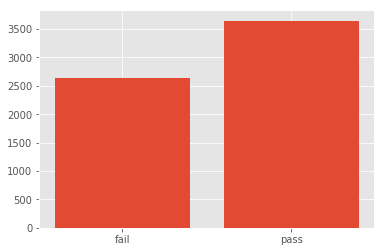

In [11]:
x_axis = ['pass', 'fail']
y_pos = [sum(Y_pass== 'pass'), sum(Y_pass =='fail')]
plt.bar(x_axis, y_pos)
plt.show()

In [ ]:
# Predictor Variables

In [12]:
predictors = [x for x in final_dset.columns if x not in ['pass', 'final_result', 'id_student','num_of_prev_attempts','code_presentation', 'code','region']]
x = final_dset[predictors]
#create dummy variables
x = pd.get_dummies(x, drop_first = False)

In [ ]:
# Random Forest full model

In [13]:
rf_full=RandomForestClassifier(n_estimators=500)

In [14]:
X_train_full, X_test_full, y_p_train_full, y_p_test_full = train_test_split(x, Y_pass, test_size=0.2)

In [15]:
model_p_full = rf_full.fit(X_train_full, y_p_train_full)
print ('Score:', model_p_full.score(X_test_full, y_p_test_full))

Score: 0.9213036565977742


In [36]:
# The full model with all of the students assessment scores, weekly virtual interaction scores, etc. Is fairly robust at predicting student failure. But this prediction is made with all data available. Or over 30 weeks of data. 
# Can student success of failure be predicted earlier?


# Model with only demographic data

# this is data of only student demographic data. So the model does not use any course information

In [16]:
lst = x.columns.tolist()
predictors0 = [x for x in lst if re.search('[0-9]', x)==None]
x0 = x[predictors0]
rf0=RandomForestClassifier(n_estimators = 500)
X_train, X_test, y_train, y_test = train_test_split(x0, Y_pass, test_size=0.2)
model_null = rf0.fit(X_train,y_train)
print ('Score:', model_null.score(X_test, y_test))

Score: 0.5906200317965024


In [ ]:
# now with only demographic data, the model can predict success of failure with about 60% accuracy

# Model with demographics and first week of data

In [37]:
predictors1 = [x for x in lst if re.search('group 19$', x)]
predictors1 = predictors0 + predictors1
x1 = x[predictors0]
rf1=RandomForestClassifier(n_estimators = 500)
X_train, X_test, y_train, y_test = train_test_split(x1, Y_pass, test_size=0.2)
model_1 = rf1.fit(X_train,y_train)
print ('Score:', model_1.score(X_test, y_test))

Score: 0.6073131955484896


In [ ]:
# slight improvement in model prediction accuracy

# Weekly Model improvement

In [18]:
df = {'model': 0, 'classification': [model_1.score(X_test, y_test)]}
df = pd.DataFrame(df)
predictor_x= [x for x in lst if re.search('[0-9]', x)==None]
test = []
for i in range(0,36):
    predictor = [x for x in lst if re.search('group ' + str(i) +'$', x)]
    predictor_x = predictor_x + predictor
    test = x[predictor_x]
    #print(test.columns)
    rf=RandomForestClassifier(n_estimators = 500)
    #rf = GradientBoostingClassifier()
    X_train, X_test, y_train, y_test = train_test_split(test, Y_pass, test_size=0.2)
    model_1 = rf.fit(X_train, y_train)
    df= df.append({'model': i+1, 'classification': model_1.score(X_test, y_test)},ignore_index=True )
    #print(df)
    print ('week' + str(i) + ' Score:', model_1.score(X_test, y_test))

week0 Score: 0.6120826709062003
week1 Score: 0.6534181240063593
week2 Score: 0.6772655007949125
week3 Score: 0.6987281399046105
week4 Score: 0.7154213036565977
week5 Score: 0.7273449920508744
week6 Score: 0.7289348171701113
week7 Score: 0.7511923688394276
week8 Score: 0.7631160572337043
week9 Score: 0.7670906200317965
week10 Score: 0.78060413354531
week11 Score: 0.7925278219395866
week12 Score: 0.7869634340222575
week13 Score: 0.8751987281399046
week14 Score: 0.8791732909379968
week15 Score: 0.8545310015898251
week16 Score: 0.8521462639109698
week17 Score: 0.8394276629570747
week18 Score: 0.8712241653418124
week19 Score: 0.8910969793322735
week20 Score: 0.8910969793322735
week21 Score: 0.8926868044515104
week22 Score: 0.8966613672496025
week23 Score: 0.9014308426073132
week24 Score: 0.9022257551669316
week25 Score: 0.910174880763116
week26 Score: 0.9157392686804452
week27 Score: 0.9260731319554849
week28 Score: 0.9213036565977742
week29 Score: 0.9236883942766295
week30 Score: 0.9332273

In [ ]:
# Steady increase in model prediction accuracy with every additional week of data. However, we see jumps at certain weeks. 
# This coincides with weeks where student had tests

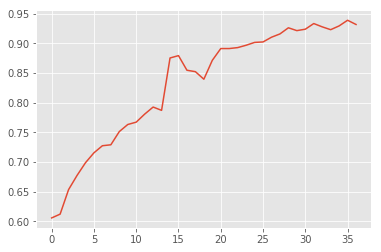

In [19]:

plt.plot(df['model'], df['classification'])
plt.show()
df.to_csv('rf.csv')

In [38]:
# by week 8, the model could predict with 75% accuracy student failure. Over 85% accuracy by week 13. And after week 24, there seems to be marginal gains, suggesting that additional student information does not add to model predictive power

# Feature importance

#  The model can predict with confidence student success and failure, but what features does the model identify as important for its prediction?

In [20]:
feature_imp = pd.DataFrame(sorted(list(zip(test.columns, model_1.feature_importances_)), key = lambda x: x[1], reverse=True)[0:20])
feature_imp

,0,1
0,score TMA group 24,0.077119
1,score TMA group 19,0.058937
2,weight TMA group 24,0.052077
3,num_assessment TMA group 24,0.051056
4,activity group 31,0.047472
5,activity group 30,0.041408
6,num_assessment TMA group 19,0.040455
7,score TMA group 13,0.032159
8,activity group 29,0.031951
9,weight TMA group 19,0.025571


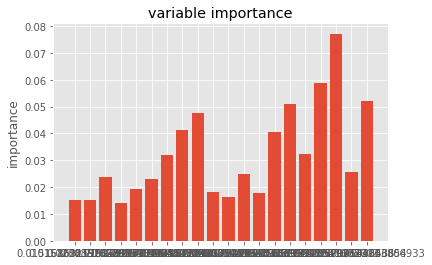

In [25]:
plt.bar(feature_imp[0], feature_imp[1], align='center', alpha=0.99)
plt.xticks(feature_imp[0], feature_imp[1])
plt.ylabel('importance')
plt.title('variable importance')
plt.show()

In [ ]:
# As expected, the strongest indicators of success and failure were tests (TMA), especially the tests taken towards the end of the course. Important online interactions mainly centered on overall activity and content activity.

# Conclusion

# As online learning continues to grow as a platform to educate students, it is important to consider how we can use the data associated with these programs to best identify students who are at risk for failure.
# I use random forests to see how early student failure can be predicted. The models showed that with demographic information alone, student failure can be predicted with 60% accuracy. As weekly information on student online interactions and assessments are added, predictions for students at risk for failure greatly increase. By week 8, the model improves to 75% accurcacy, and has over 85% accuracy by week 13.
# As educators continue to seek ways to identify students at risk for failure, this model provides a robust way to do so. However, it is not enough to find students at risk for failure. Intervention needs to be implemented to best understand how to improve the outcomes of these students.